In [0]:
!pip install transformers==2.9.0
import os
import re
import sys
import random
import string
import math
import time
import pickle
import ast
import collections as C
import copy
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.utils import shuffle
from sklearn.model_selection import *
from sklearn.metrics import *
from matplotlib import pyplot as plt
from ast import literal_eval
import transformers
import seaborn as sns
from transformers import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Aspect

## Load Data

Data Loading and Tokenization taken from [BERT-Aspect by Avinash](https://github.com/avinashsai/BERT-Aspect)

In [0]:
!wget https://raw.githubusercontent.com/nvshrao/Temp/master/data/GCAE-master/atsa-restaurant/atsa_train.json
!wget https://raw.githubusercontent.com/nvshrao/Temp/master/data/GCAE-master/atsa-restaurant/atsa_test.json

--2020-05-16 13:44:45--  https://raw.githubusercontent.com/nvshrao/Temp/master/data/GCAE-master/atsa-restaurant/atsa_train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 597248 (583K) [text/plain]
Saving to: ‘atsa_train.json.3’

atsa_train.json.3   100%[===================>] 583.25K  --.-KB/s    in 0.04s   

2020-05-16 13:44:46 (14.1 MB/s) - ‘atsa_train.json.3’ saved [597248/597248]

--2020-05-16 13:44:48--  https://raw.githubusercontent.com/nvshrao/Temp/master/data/GCAE-master/atsa-restaurant/atsa_test.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting respo

In [0]:
label = {'negative':0,'positive':1,'neutral':2}

def load_data(dataset = ''):
  temp = open(dataset + "atsa_train.json", "r", encoding = "ISO-8859-1").read()
  train = literal_eval(temp)
  train_sentence = []
  train_aspect = []
  train_sentiment = []
  for xml in train:
    if(xml['sentiment']!='conflict'):
      train_sentence.append(xml["sentence"])
      train_aspect.append(xml["aspect"])
      train_sentiment.append(label[xml["sentiment"]])
  temp = open(dataset + "atsa_test.json", "r", encoding = "ISO-8859-1").read()
  test = literal_eval(temp)
  test_sentence = []
  test_aspect = []
  test_sentiment = []
  for xml in test:
    if(xml['sentiment']!='conflict'):
      test_sentence.append(xml["sentence"])
      test_aspect.append(xml["aspect"])
      test_sentiment.append(label[xml["sentiment"]])
  return train_sentence, test_sentence, train_aspect, test_aspect, train_sentiment, test_sentiment

In [0]:
train_sentence, test_sentence, train_aspect, test_aspect, train_sentiment, test_sentiment = load_data()

assert len(train_sentence) == len(train_aspect)
assert len(train_aspect) == len(train_sentiment)

assert len(test_sentence) == len(test_aspect)
assert len(test_aspect) == len(test_sentiment)

In [0]:
sentence_lengths = [len(sentence.split()) for sentence in train_sentence]
aspect_lengths = [len(aspect.split()) for aspect in train_aspect]

max_sentence_length = max(sentence_lengths)
max_aspect_length = max(aspect_lengths)

print("Maximum Sentence Length: {} ".format(max_sentence_length))
print("Maximum Aspect Length: {} ".format(max_aspect_length))

Maximum Sentence Length: 69 
Maximum Aspect Length: 19 


In [0]:
train_sentence, dev_sentence, train_aspect, dev_aspect, train_labels, dev_labels = train_test_split(train_sentence,
                                                                                                    train_aspect,
                                                                                                    train_sentiment,
                                                                                                    test_size=0.1,
                                                                                                    random_state=42)

In [0]:
print("Training Data Size: {} ".format(len(train_sentence)))
print("Validation Data Size: {} ".format(len(dev_sentence)))

Training Data Size: 3241 
Validation Data Size: 361 


## Tokenize

In [0]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [0]:
def tokenize_sentences(sentences, aspects,T):
  input_ids = []
  attention_masks = []
  token_type_ids = []
  tokenized_sentences=[]

  for sentence, aspect in zip(sentences, aspects):

    encoded = bert_tokenizer.encode_plus(text=sentence,
                                        text_pair=aspect,
                                        add_special_tokens=True,
                                        max_length=T,
                                        pad_to_max_length=True,
                                        return_attention_masks=True,
                                        return_token_type_ids=True)
    tokenized_sentence = bert_tokenizer.convert_ids_to_tokens(encoded['input_ids'])
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])
    token_type_ids.append(encoded['token_type_ids'])
    tokenized_sentences.append(tokenized_sentence)
  input_ids = np.array(input_ids)
  attention_masks = np.array(attention_masks)
  token_type_ids = np.array(token_type_ids)
  return input_ids, attention_masks, token_type_ids,tokenized_sentences

## BERT LSTM Model

Architecture Described in [Utilizing BERT Intermediate Layers for Aspect Based Sentiment Analysis and Natural Language Inference](https://arxiv.org/pdf/2002.04815.pdf)

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation,concatenate,Embedding,LSTM,Conv1D,MaxPooling1D,Flatten,Input,Bidirectional, Input
from tensorflow.keras.layers import Subtract,Lambda,Add,Conv1D,Reshape,Dropout,Permute
from transformers import BertTokenizer, TFBertForSequenceClassification,TFBertModel, TFDistilBertModel, DistilBertTokenizer, TFAlbertModel , AlbertTokenizer
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import plot_model,to_categorical

In [0]:
def create_model(T):
  model_base = TFBertModel.from_pretrained('bert-base-uncased',output_hidden_states=True,output_attentions=True)
  In=Input(shape=(T,),name="Input_Sentence",dtype=np.int64)
  At=Input(shape=(T,),name="Attention_Mask",dtype=np.int64)
  To=Input(shape=(T,),name="Token_Type",dtype=np.int64)
  ############################
  o1,o2,o3,o4=model_base([In,At,To])
  ##########################
  o = K.stack(o3,axis=-1)
  o=tf.convert_to_tensor(o)
  #print(o.shape)
  o = Permute((1,3,2))(o)
  o=o[:,0,:,:]
  o=o[:,1:,:]# since first is embedding
  o=LSTM(64,return_sequences=False)(o)
  o=Dropout(0.1)(o)
  o=Dense(3,activation="softmax")(o)
  model_o=Model(inputs=[In,At,To],outputs=[o])
  attentionmodel=Model(inputs=[In,At,To],outputs=[o4])
  return model_o,attentionmodel

In [0]:
T=80
m1,m2=create_model(T)
m1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Sentence (InputLayer)     [(None, 80)]         0                                            
__________________________________________________________________________________________________
Attention_Mask (InputLayer)     [(None, 80)]         0                                            
__________________________________________________________________________________________________
Token_Type (InputLayer)         [(None, 80)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 80, 768), (N 109482240   Input_Sentence[0][0]             
                                                                 Attention_Mask[0][0]         

In [0]:
train_input_ids, train_attention_masks, train_token_type_ids,train_tokenized_sentences = tokenize_sentences(train_sentence, train_aspect,T=T)
dev_input_ids, dev_attention_masks, dev_token_type_ids,dev_tokenized_sentences = tokenize_sentences(dev_sentence, dev_aspect,T=T)
test_input_ids, test_attention_masks, test_token_type_ids,test_tokenized_sentences = tokenize_sentences(test_sentence, test_aspect,T=T)

In [0]:
r = m2.predict([dev_input_ids, dev_attention_masks, dev_token_type_ids])
r = np.array(r)
r.shape

(1, 12, 361, 12, 80, 80)

In [0]:
i=5
print(train_tokenized_sentences[i])

['[CLS]', 'the', 'br', '##us', '##chet', '##ta', 'is', 'a', 'bit', 'so', '##ggy', ',', 'but', 'the', 'salad', '##s', 'were', 'fresh', ',', 'included', 'a', 'nice', 'mix', 'of', 'greens', '(', 'not', 'ice', '##berg', ')', 'all', 'dishes', 'are', 'served', 'pip', '##ing', 'hot', 'from', 'the', 'kitchen', '.', '[SEP]', 'ice', '##berg', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [0]:
print(train_input_ids[i])

[  101  1996  7987  2271 20318  2696  2003  1037  2978  2061 22772  1010
  2021  1996 16521  2015  2020  4840  1010  2443  1037  3835  4666  1997
 15505  1006  2025  3256  4059  1007  2035 10447  2024  2366 28315  2075
  2980  2013  1996  3829  1012   102  3256  4059   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [0]:
print(train_attention_masks[i])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


In [0]:
print(train_token_type_ids[i])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


## Training

In [0]:
test_labels = test_sentiment
train_labels_categorical = to_categorical(train_labels)
dev_labels_categorical  = to_categorical(dev_labels)
test_labels_categorical  = to_categorical(test_labels)

In [0]:
e=10
lr=2e-5
custom_adam = tf.keras.optimizers.Adam(learning_rate=lr,epsilon=1e-8,decay=0.01)

In [0]:
def fit_model(XX,yy,model,verbose=0,epochs=e):
  model.compile(loss="categorical_crossentropy",metrics=["acc"],optimizer=custom_adam)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=5,restore_best_weights=True)
  history=model.fit(x=XX,y=yy,epochs=epochs,batch_size=8,validation_data=([dev_input_ids, dev_attention_masks, dev_token_type_ids],dev_labels_categorical),callbacks=[es],verbose=verbose)
  return model,history

In [0]:
print(train_input_ids.shape,train_labels_categorical.shape,test_input_ids.shape, test_labels_categorical.shape,dev_input_ids.shape, dev_labels_categorical.shape)

(3241, 80) (3241, 3) (1120, 80) (1120, 3) (361, 80) (361, 3)


Epoch 1/10
406/406 [==============================] - 136s 335ms/step - loss: 0.6888 - acc: 0.7093 - val_loss: 0.5942 - val_acc: 0.7479
Epoch 2/10
406/406 [==============================] - 132s 324ms/step - loss: 0.4777 - acc: 0.8180 - val_loss: 0.5629 - val_acc: 0.7618
Epoch 3/10
406/406 [==============================] - 132s 325ms/step - loss: 0.4106 - acc: 0.8396 - val_loss: 0.5532 - val_acc: 0.7729
Epoch 4/10
406/406 [==============================] - 132s 326ms/step - loss: 0.3637 - acc: 0.8605 - val_loss: 0.5460 - val_acc: 0.7729
Epoch 5/10
406/406 [==============================] - 132s 325ms/step - loss: 0.3346 - acc: 0.8744 - val_loss: 0.5486 - val_acc: 0.7756
Epoch 6/10
406/406 [==============================] - 132s 326ms/step - loss: 0.3127 - acc: 0.8843 - val_loss: 0.5500 - val_acc: 0.7812
Epoch 7/10
406/406 [==============================] - 132s 325ms/step - loss: 0.2934 - acc: 0.8929 - val_loss: 0.5483 - val_acc: 0.7867
Epoch 8/10
406/406 [============================

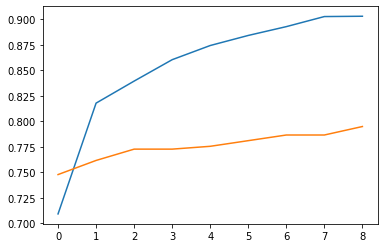

Epoch 1/10
406/406 [==============================] - 136s 335ms/step - loss: 0.9203 - acc: 0.5875 - val_loss: 0.8222 - val_acc: 0.6288
Epoch 2/10
406/406 [==============================] - 132s 325ms/step - loss: 0.8289 - acc: 0.6347 - val_loss: 0.7649 - val_acc: 0.6648
Epoch 3/10
406/406 [==============================] - 132s 326ms/step - loss: 0.7682 - acc: 0.6726 - val_loss: 0.7152 - val_acc: 0.7036
Epoch 4/10
406/406 [==============================] - 132s 326ms/step - loss: 0.7029 - acc: 0.7109 - val_loss: 0.6704 - val_acc: 0.7396
Epoch 5/10
406/406 [==============================] - 132s 325ms/step - loss: 0.6599 - acc: 0.7408 - val_loss: 0.6445 - val_acc: 0.7618
Epoch 6/10
406/406 [==============================] - 132s 325ms/step - loss: 0.6262 - acc: 0.7566 - val_loss: 0.6274 - val_acc: 0.7562
Epoch 7/10
406/406 [==============================] - 132s 324ms/step - loss: 0.5998 - acc: 0.7624 - val_loss: 0.6186 - val_acc: 0.7562
Epoch 8/10
406/406 [============================

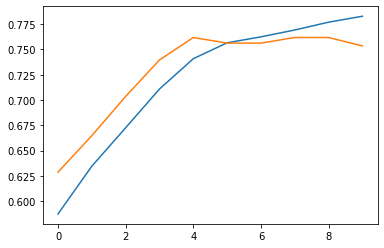

Epoch 1/10
406/406 [==============================] - 136s 334ms/step - loss: 0.9587 - acc: 0.5724 - val_loss: 0.8690 - val_acc: 0.6233
Epoch 2/10
406/406 [==============================] - 131s 323ms/step - loss: 0.8999 - acc: 0.6041 - val_loss: 0.8446 - val_acc: 0.6233
Epoch 3/10
406/406 [==============================] - 132s 324ms/step - loss: 0.8746 - acc: 0.6112 - val_loss: 0.8266 - val_acc: 0.6233
Epoch 4/10
406/406 [==============================] - 132s 325ms/step - loss: 0.8457 - acc: 0.6189 - val_loss: 0.8045 - val_acc: 0.6399
Epoch 5/10
406/406 [==============================] - 132s 325ms/step - loss: 0.8264 - acc: 0.6353 - val_loss: 0.7854 - val_acc: 0.6510
Epoch 6/10
406/406 [==============================] - 132s 324ms/step - loss: 0.8073 - acc: 0.6452 - val_loss: 0.7660 - val_acc: 0.6704
Epoch 7/10
406/406 [==============================] - 132s 325ms/step - loss: 0.7879 - acc: 0.6560 - val_loss: 0.7470 - val_acc: 0.6842
Epoch 8/10
406/406 [============================

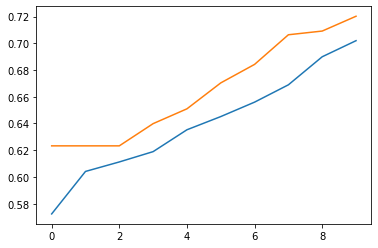

Epoch 1/10
406/406 [==============================] - 136s 335ms/step - loss: 0.9827 - acc: 0.5501 - val_loss: 0.8850 - val_acc: 0.6205
Epoch 2/10
406/406 [==============================] - 133s 327ms/step - loss: 0.9219 - acc: 0.6001 - val_loss: 0.8683 - val_acc: 0.6205
Epoch 3/10
406/406 [==============================] - 132s 326ms/step - loss: 0.9042 - acc: 0.5992 - val_loss: 0.8563 - val_acc: 0.6233
Epoch 4/10
406/406 [==============================] - 132s 325ms/step - loss: 0.8840 - acc: 0.6057 - val_loss: 0.8427 - val_acc: 0.6233
Epoch 5/10
406/406 [==============================] - 132s 325ms/step - loss: 0.8736 - acc: 0.6115 - val_loss: 0.8304 - val_acc: 0.6233
Epoch 6/10
406/406 [==============================] - 132s 326ms/step - loss: 0.8630 - acc: 0.6122 - val_loss: 0.8187 - val_acc: 0.6316
Epoch 7/10
406/406 [==============================] - 132s 325ms/step - loss: 0.8521 - acc: 0.6152 - val_loss: 0.8076 - val_acc: 0.6371
Epoch 8/10
406/406 [============================

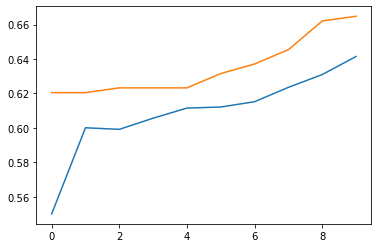

Epoch 1/10
406/406 [==============================] - 135s 333ms/step - loss: 1.0044 - acc: 0.5319 - val_loss: 0.8947 - val_acc: 0.6205
Epoch 2/10
406/406 [==============================] - 132s 324ms/step - loss: 0.9340 - acc: 0.5986 - val_loss: 0.8802 - val_acc: 0.6205
Epoch 3/10
406/406 [==============================] - 132s 326ms/step - loss: 0.9190 - acc: 0.5955 - val_loss: 0.8708 - val_acc: 0.6205
Epoch 4/10
406/406 [==============================] - 132s 326ms/step - loss: 0.9021 - acc: 0.6032 - val_loss: 0.8609 - val_acc: 0.6233
Epoch 5/10
406/406 [==============================] - 133s 327ms/step - loss: 0.8955 - acc: 0.6044 - val_loss: 0.8515 - val_acc: 0.6233
Epoch 6/10
406/406 [==============================] - 132s 326ms/step - loss: 0.8882 - acc: 0.6066 - val_loss: 0.8430 - val_acc: 0.6233
Epoch 7/10
406/406 [==============================] - 132s 324ms/step - loss: 0.8805 - acc: 0.6063 - val_loss: 0.8349 - val_acc: 0.6233
Epoch 8/10
406/406 [============================

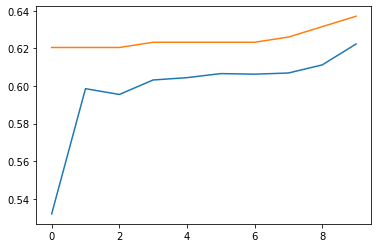

In [0]:
acc=[]
modelspairs=[]
for i in np.arange(5):
  tf.random.set_seed(1)
  np.random.seed(1)
  model_o,atten_model = create_model(T)
  model_o,history = fit_model([train_input_ids, train_attention_masks, train_token_type_ids],train_labels_categorical,model_o,verbose=1,epochs=e)
  acc.append(model_o.evaluate([test_input_ids, test_attention_masks, test_token_type_ids],test_labels_categorical)[1])
  print(acc)
  plt.plot(history.history["acc"])
  plt.plot(history.history["val_acc"])
  plt.show()
  modelspairs.append([model_o,atten_model])

In [0]:
acc # 2nd 10

[0.8089285492897034,
 0.7901785969734192,
 0.7339285612106323,
 0.6946428418159485,
 0.6660714149475098]

## Attention Visualization

In [0]:
colors = ["Accent","Accent_r","Blues","Blues_r","BrBG","BrBG_r","BuGn","BuGn_r","BuPu","BuPu_r","CMRmap","CMRmap_r","Dark2","Dark2_r","GnBu","GnBu_r","Greens","Greens_r","Greys","Greys_r","OrRd","OrRd_r","Oranges","Oranges_r","PRGn","PRGn_r","Paired","Paired_r","Pastel1","Pastel1_r","Pastel2","Pastel2_r","PiYG","PiYG_r","PuBu","PuBuGn","PuBuGn_r","PuBu_r","PuOr","PuOr_r","PuRd","PuRd_r","Purples","Purples_r","RdBu","RdBu_r","RdGy","RdGy_r","RdPu","RdPu_r","RdYlBu","RdYlBu_r","RdYlGn","RdYlGn_r","Reds","Reds_r","Set1","Set1_r","Set2","Set2_r","Set3","Set3_r","Spectral","Spectral_r","Wistia","Wistia_r","YlGn","YlGnBu","YlGnBu_r","YlGn_r","YlOrBr","YlOrBr_r","YlOrRd","YlOrRd_r","afmhot","afmhot_r","autumn","autumn_r","binary","binary_r","bone","bone_r","brg","brg_r","bwr","bwr_r","cividis","cividis_r","cool","cool_r","coolwarm","coolwarm_r","copper","copper_r","cubehelix","cubehelix_r","flag","flag_r","gist_earth","gist_earth_r","gist_gray","gist_gray_r","gist_heat","gist_heat_r","gist_ncar","gist_ncar_r","gist_rainbow","gist_rainbow_r","gist_stern","gist_stern_r","gist_yarg","gist_yarg_r","gnuplot","gnuplot2","gnuplot2_r","gnuplot_r","gray","gray_r","hot","hot_r","hsv","hsv_r","icefire","icefire_r","inferno","inferno_r","jet","jet_r","magma","magma_r","mako","mako_r","nipy_spectral","nipy_spectral_r","ocean","ocean_r","pink","pink_r","plasma","plasma_r","prism","prism_r","rainbow","rainbow_r","rocket","rocket_r","seismic","seismic_r","spring","spring_r","summer","summer_r","tab10","tab10_r","tab20","tab20_r","tab20b","tab20b_r","tab20c"]

In [0]:
def visualize_sentence(sentence,aspect,truelabel,modelpair,hide_pad=False):
  model,attenmodel=modelpair
  a,b,c,d = tokenize_sentences([sentence],[aspect],T)
  print(" ".join(d[0][:-d[0].count("[PAD]")]))
  print("Prediction:",np.argmax(model.predict([a,b,c])[0])==truelabel)
  attentions = np.array(attenmodel.predict([a,b,c]))
  print(attentions.shape)
  attentions = attentions.reshape(12,12,T,T)
  attentions = attentions.reshape(144,T,T)
  attentions = np.mean(attentions,axis=0)
  if hide_pad==False:
    fig, ax = plt.subplots(figsize=(15,10))
    sns.heatmap(attentions,xticklabels=d[0],yticklabels=d[0])
    plt.show()
  if hide_pad==True:
    num_pads = d[0].count("[PAD]")
    fig, ax = plt.subplots(figsize=((T-num_pads)/4,(T-num_pads-2)/4))
    sns.heatmap(attentions[:-num_pads,:-num_pads],xticklabels=d[0][:-num_pads],yticklabels=d[0][:-num_pads],cmap=random.choice(colors))
    plt.show()

[CLS] you will not be di ##ssa ##point ##ed by any of the choices in the menu . [SEP] menu [SEP]
Prediction: False
(1, 12, 1, 12, 80, 80)


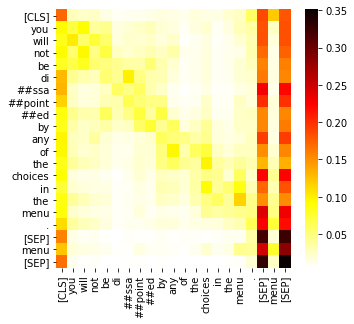

[CLS] thick fries , meat ##y chili and stuffed baked potatoes round out a menu that includes a cool , ultra - thick chocolate frost ##y . [SEP] stuffed baked potatoes [SEP]
Prediction: False
(1, 12, 1, 12, 80, 80)


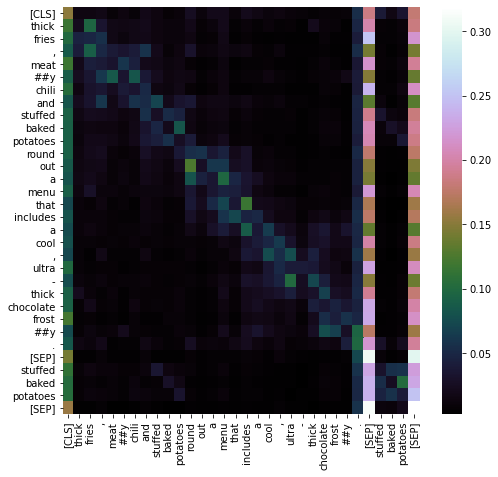

[CLS] en ##tree ##s include classics like las ##ag ##na , fe ##tt ##ucci ##ne alfredo and chicken par ##mi ##gia ##na . [SEP] fe ##tt ##ucci ##ne alfredo [SEP]
Prediction: False
(1, 12, 1, 12, 80, 80)


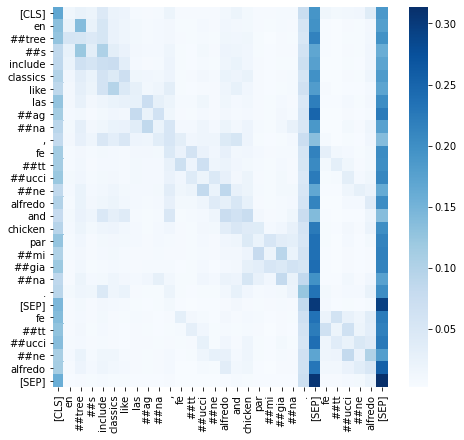

[CLS] great food , great waits ##taff , great atmosphere , and best of all great beer ! [SEP] food [SEP]
Prediction: True
(1, 12, 1, 12, 80, 80)


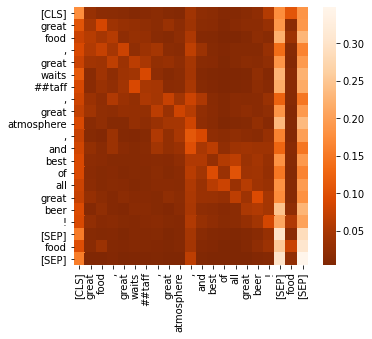

[CLS] you must try the garlic soup ! [SEP] garlic soup [SEP]
Prediction: True
(1, 12, 1, 12, 80, 80)


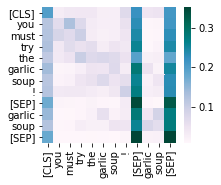

[CLS] the am ##bie ##nce is also more laid - back and relaxed . [SEP] am ##bie ##nce [SEP]
Prediction: True
(1, 12, 1, 12, 80, 80)


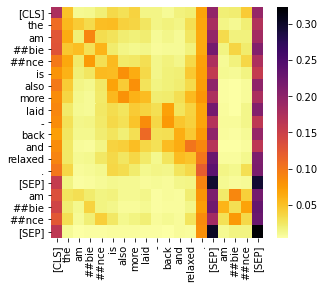

[CLS] for a sa ##vor ##y take on the soup and sandwich meal , try the hot and sour soup . [SEP] hot and sour soup [SEP]
Prediction: True
(1, 12, 1, 12, 80, 80)


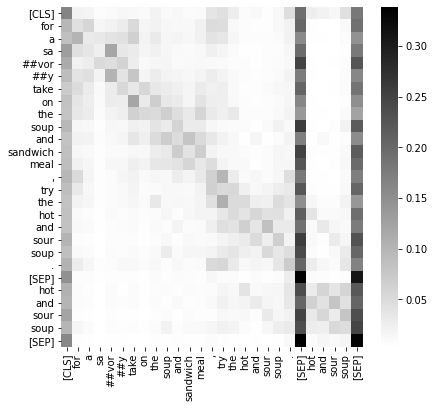

[CLS] dishes denoted as " roy ' s classics " ( marked on the menu with as ##ter ##isk ##s ) are tried - and - true recipes , such as mac ##ada ##mia - crust ##ed ma ##hi ma ##hi , or subtly sweet honey - mustard beef short ribs . [SEP] recipes [SEP]
Prediction: True
(1, 12, 1, 12, 80, 80)


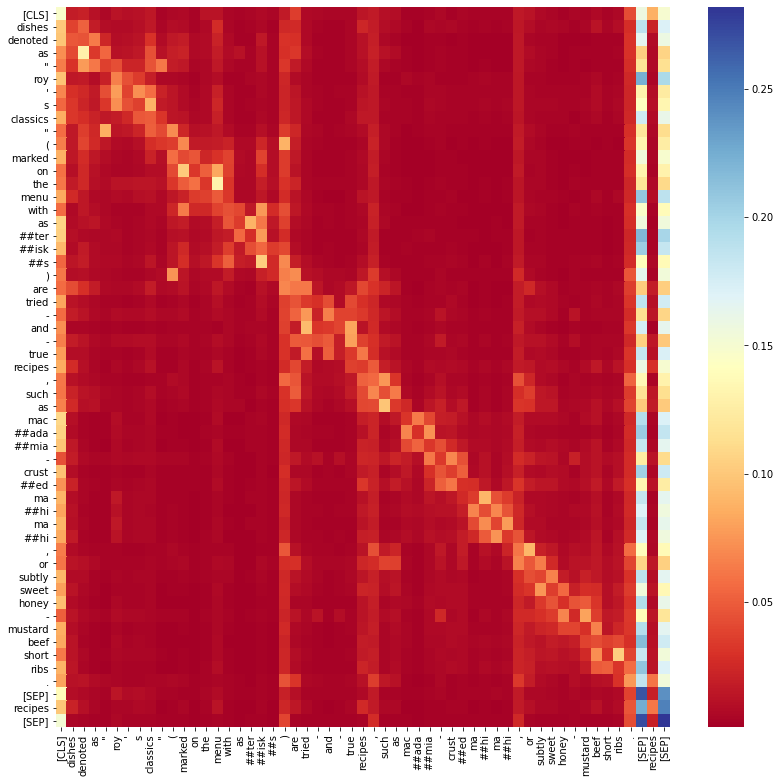

[CLS] innovations are just as assured , from the simple car ##int ##hia cheese ravi ##oli with wild mushrooms to the ca ##via ##r - topped stu ##rgeon , beautifully matched with a bright green spin ##ach - vodka sauce . [SEP] ca ##via ##r - topped stu ##rgeon [SEP]
Prediction: True
(1, 12, 1, 12, 80, 80)


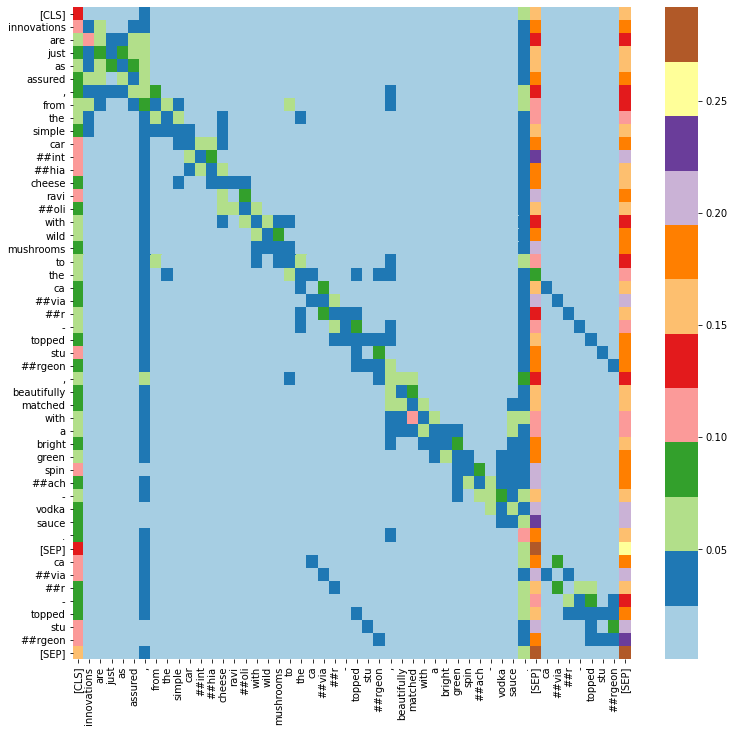

[CLS] the lone argentine cho ##riz ##o app ##eti ##zer at $ 8 . 95 was a heavy fen ##nel flavor ##ed italian sausage like the ones that sell for $ 2 . 99 / lb at the store . [SEP] argentine cho ##riz ##o app ##eti ##zer [SEP]
Prediction: False
(1, 12, 1, 12, 80, 80)


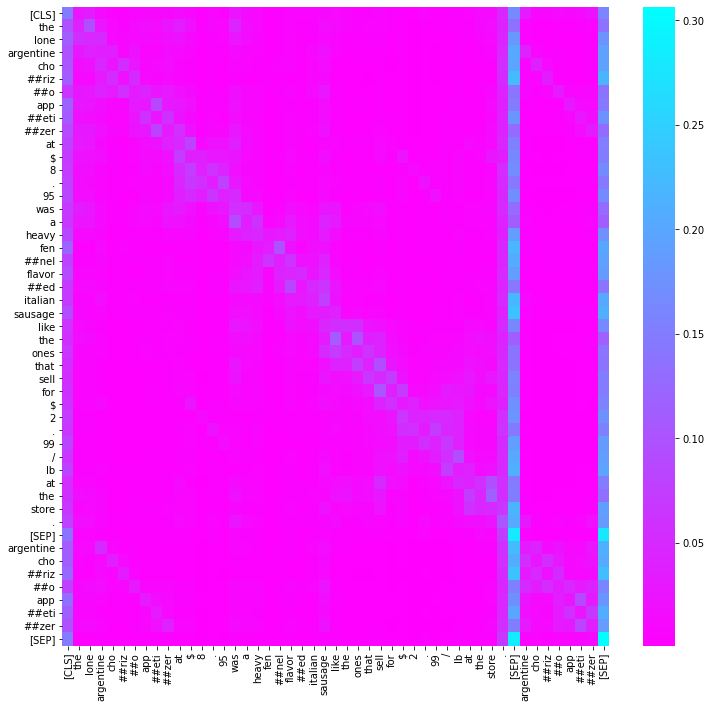

[CLS] the food really isn ' t very good and the service is terrible . [SEP] food [SEP]
Prediction: True
(1, 12, 1, 12, 80, 80)


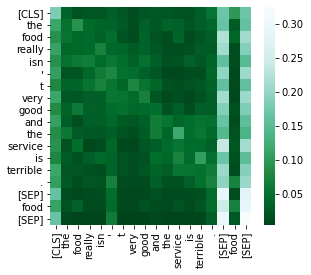

[CLS] stick to the items the place does best , brisk ##et , ribs , wings , ca ##jun shrimp is good , not great . [SEP] ribs [SEP]
Prediction: True
(1, 12, 1, 12, 80, 80)


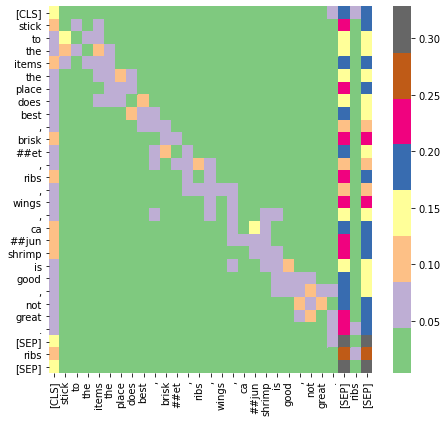

[CLS] the waiter ##s were very professional , court ##eous and at ##ten ##tive . [SEP] waiter ##s [SEP]
Prediction: True
(1, 12, 1, 12, 80, 80)


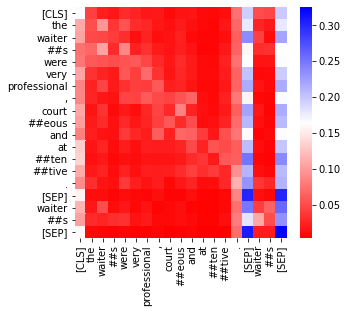

[CLS] the service , however , is a peg or two below the quality of food ( horrible bartender ##s ) , and the client ##ele , for the most part , are row ##dy , loud - mouthed commuter ##s ( this could explain the bad attitudes from the staff ) getting loaded for an ac / dc concert or a knicks game . [SEP] bartender ##s [SEP]
Prediction: True
(1, 12, 1, 12, 80, 80)


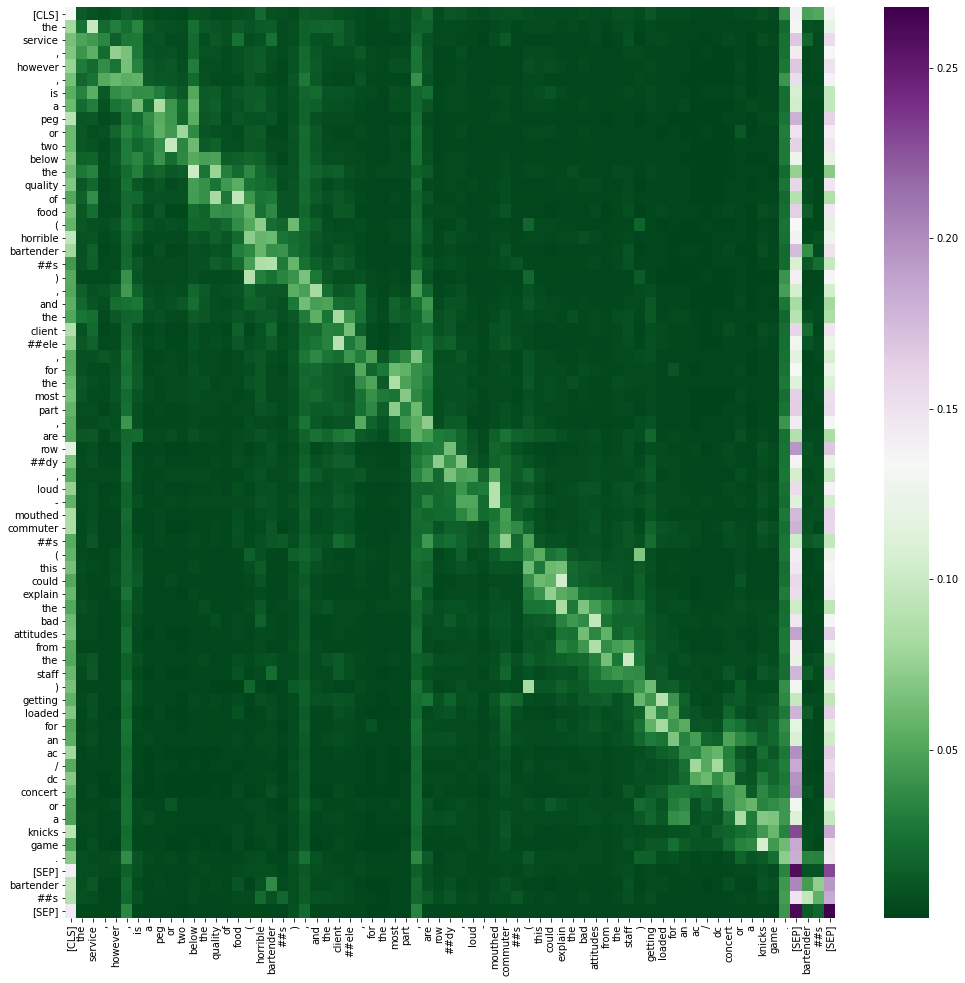

[CLS] the pasta prima ##vera was outstanding as well , lots of fresh ve ##gg ##ies . [SEP] pasta prima ##vera [SEP]
Prediction: True
(1, 12, 1, 12, 80, 80)


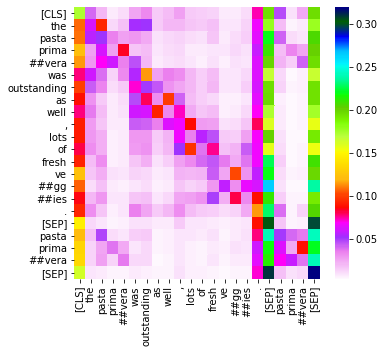

[CLS] they have an excellent selection ( the rolls with crab are really great ) . [SEP] rolls with crab [SEP]
Prediction: True
(1, 12, 1, 12, 80, 80)


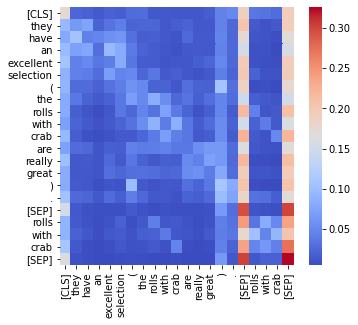

[CLS] we ordered lamb which was perfectly cooked and tasted awesome . [SEP] lamb [SEP]
Prediction: True
(1, 12, 1, 12, 80, 80)


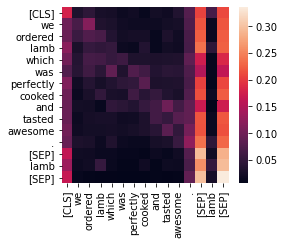

[CLS] the downstairs bar scene is very cool and chill . . . [SEP] downstairs bar scene [SEP]
Prediction: True
(1, 12, 1, 12, 80, 80)


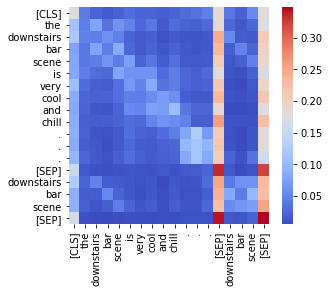

[CLS] cuisine is billed as asian fusion - doesn ' t meet the bill . [SEP] billed [SEP]
Prediction: True
(1, 12, 1, 12, 80, 80)


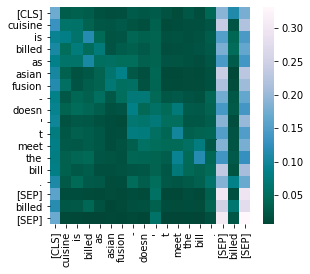

[CLS] the one positive thing i can say is that the service was prompt , we got seated right away and the server was very friendly . [SEP] server [SEP]
Prediction: True
(1, 12, 1, 12, 80, 80)


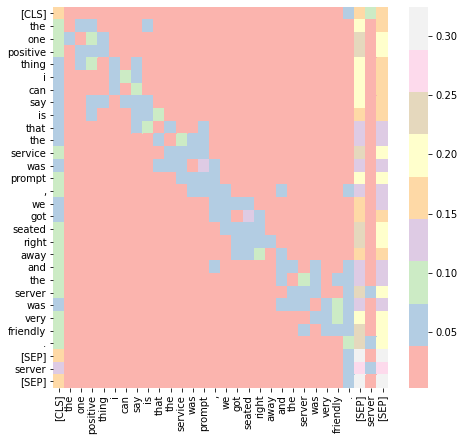

In [0]:
for i in random.sample(list(np.arange(1, len(test_labels))), 20):
  visualize_sentence(test_sentence[i],test_aspect[i],test_labels[i],modelspairs[0],hide_pad=True)

# Rough